In [16]:
# import all necessary libraries
!pip install mysql-connector-python
!pip install vaderSentiment
!pip install tensorflow
!pip install keras
!pip install protobuf
!pip install grpcio
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow
import keras
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import time
import json
import re
import math
import pickle
from datetime import datetime
from datetime import timedelta
import requests
from requests.auth import AuthBase
import config
import tools
import mysql.connector
import urllib.parse
from mysql.connector import errorcode
import sqlite3
%matplotlib inline
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

In [45]:
# reload our tweets from pickle checkpoint
with open("pickle-folder/tsla_week2_tweets.pkl", 'rb') as f:
    df1 = pickle.load(f)
df1

,tweet,id,price,compound_sentiment,positive_sentiment,negative_sentiment,neutral_sentiment
datetime,,,,,,,
2020-05-20 09:01:00,RT @vieiraUAE: FED and Billionaire 10 Reasons ...,1263031795374751744,null,0.0000,0.000,0.000,1.000
2020-05-20 09:01:00,RT @vieiraUAE: Tesla is VERY CHEAP! BUY NOW1 C...,1263031874194214912,null,0.0000,0.000,0.000,1.000
2020-05-20 09:02:00,RT @vieiraUAE: Alex Vieira Says NVIDIA Better ...,1263032010022453248,null,0.4404,0.153,0.000,0.847
2020-05-20 09:02:00,"RT @vieiraUAE: Buy Now Tesla Upgraded to $1,20...",1263032001516449794,null,0.0000,0.000,0.000,1.000
2020-05-20 09:02:00,RT @vieiraUAE: Traders Choose ALGO to Invest i...,1263032038090780675,null,0.0000,0.000,0.000,1.000
...,...,...,...,...,...,...,...
2020-05-22 22:58:00,@HarryMKaplan @HackItMax @marvinliao So you do...,1263967140681519113,null,0.0000,0.000,0.000,1.000
2020-05-22 22:59:00,"If Tesla made a minivan, this is what the Mode...",1263967518508503040,null,0.3612,0.111,0.000,0.889
2020-05-22 22:59:00,Uh oh TSLAQ dummies. More smart ppl on team T...,1263967534669275137,null,0.4576,0.230,0.000,0.770


In [46]:
# read in pickle file from alphavantage api call
with open('pickle-folder/tsla_week3_price.pkl', 'rb') as f:
    tsla_data = pickle.load(f)
# create a new column containing average price, calculated as arithmetic average of open and close
tsla_data['avg_price'] = ((tsla_data['1. open'] + tsla_data['4. close'])/2.0)
tsla_data = tsla_data[:'2020-05-22 16:00:00']
tsla_data

,1. open,2. high,3. low,4. close,5. volume,avg_price
date,,,,,,
2020-05-20 09:31:00,819.8700,824.8500,819.0195,823.6000,271310.0,821.73500
2020-05-20 09:32:00,823.8100,824.0400,820.1200,821.2649,49124.0,822.53745
2020-05-20 09:33:00,821.4300,822.9200,818.5000,819.2384,70079.0,820.33420
2020-05-20 09:34:00,819.0875,819.6700,817.1100,819.0000,43856.0,819.04375
2020-05-20 09:35:00,818.9782,819.5831,816.6600,816.9089,31130.0,817.94355
...,...,...,...,...,...,...
2020-05-22 15:56:00,817.4200,817.6900,816.7430,817.1100,29073.0,817.26500
2020-05-22 15:57:00,817.0999,817.6300,816.8300,817.2900,31711.0,817.19495
2020-05-22 15:58:00,817.5000,817.7500,816.6600,816.7896,33391.0,817.14480


In [47]:
# capture tweet volume information
df1['tweet_count'] = [1 for i in range(len(df1.index))]
count_only = df1['tweet_count'].groupby('datetime').sum()
count_only

datetime
2020-05-20 09:01:00    2
2020-05-20 09:02:00    3
2020-05-20 09:03:00    1
2020-05-20 09:04:00    2
2020-05-20 09:05:00    1
                      ..
2020-05-22 22:55:00    1
2020-05-22 22:56:00    1
2020-05-22 22:58:00    2
2020-05-22 22:59:00    2
2020-05-22 23:00:00    2
Name: tweet_count, Length: 2874, dtype: int64

In [48]:
# discard all but the sentiment and volume information from our tweet dataframe
sent_only = df1.drop(columns=['tweet','id','price']).groupby('datetime').mean()
sent_only['tweet_count'] = count_only
sent_only

,compound_sentiment,positive_sentiment,negative_sentiment,neutral_sentiment,tweet_count
datetime,,,,,
2020-05-20 09:01:00,0.00000,0.0000,0.0000,1.0000,2
2020-05-20 09:02:00,0.14680,0.0510,0.0000,0.9490,3
2020-05-20 09:03:00,0.00000,0.0000,0.0000,1.0000,1
2020-05-20 09:04:00,0.10115,0.0350,0.0000,0.9650,2
2020-05-20 09:05:00,0.72450,0.3360,0.0000,0.6640,1
...,...,...,...,...,...
2020-05-22 22:55:00,0.00000,0.0000,0.0000,1.0000,1
2020-05-22 22:56:00,0.00000,0.0000,0.0000,1.0000,1
2020-05-22 22:58:00,-0.44300,0.0360,0.1655,0.7985,2


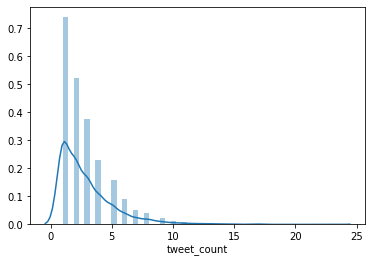

In [49]:
# quick visual of tweet volume distribution
sns.distplot(sent_only['tweet_count'])

In [50]:
# convert from UTC to EST, as twitter API defaults to UTC, but AlphaVantage defaults to EST
sent_only['eastern_time'] = sent_only.index - timedelta(hours = 4)
sent_only.set_index('eastern_time', drop=True, inplace=True)
sent_only

,compound_sentiment,positive_sentiment,negative_sentiment,neutral_sentiment,tweet_count
eastern_time,,,,,
2020-05-20 05:01:00,0.00000,0.0000,0.0000,1.0000,2
2020-05-20 05:02:00,0.14680,0.0510,0.0000,0.9490,3
2020-05-20 05:03:00,0.00000,0.0000,0.0000,1.0000,1
2020-05-20 05:04:00,0.10115,0.0350,0.0000,0.9650,2
2020-05-20 05:05:00,0.72450,0.3360,0.0000,0.6640,1
...,...,...,...,...,...
2020-05-22 18:55:00,0.00000,0.0000,0.0000,1.0000,1
2020-05-22 18:56:00,0.00000,0.0000,0.0000,1.0000,1
2020-05-22 18:58:00,-0.44300,0.0360,0.1655,0.7985,2


In [51]:
# chunk up our price dataframe into trading days
wed = tsla_data.loc['2020-05-20 09:31':'2020-05-20 16:00:00']
thur = tsla_data.loc['2020-05-21 09:31':'2020-05-21 16:00:00']
fri = tsla_data.loc['2020-05-22 09:31':'2020-05-22 16:00:00']

# add padding to the beginning of our price series so it aligns with our tweets
a = wed.index[0]
mins = int(60*4.5) + 1
timeList = []
for x in range (0, mins):
    timeList.append(a - timedelta(minutes = x))
timeList = timeList[1:]
time_adj_df1 = pd.DataFrame(timeList)
time_adj_df1['1. open'] = np.NaN
time_adj_df1['2. high'] = np.NaN
time_adj_df1['3. low'] = np.NaN
time_adj_df1['4. close'] = np.NaN
time_adj_df1['5. volume'] = np.NaN
time_adj_df1['avg_price'] = np.NaN
time_adj_df1 = time_adj_df1[::-1]
time_adj_df1['date'] = time_adj_df1[0]
time_adj_df1.set_index('date', drop=True, inplace=True)
time_adj_df1.drop(columns=[0], inplace=True)


# create datapoints for wednesday night so our data remains continuous
a = thur.index[0]
mins = int(60*17.5) + 1
timeList = []
for x in range (0, mins):
    timeList.append(a - timedelta(minutes = x))
timeList = timeList[1:]
wed_night = pd.DataFrame(timeList)
wed_night['1. open'] = np.NaN
wed_night['2. high'] = np.NaN
wed_night['3. low'] = np.NaN
wed_night['4. close'] = np.NaN
wed_night['5. volume'] = np.NaN
wed_night['avg_price'] = np.NaN
wed_night = wed_night[::-1]
wed_night['date'] = wed_night[0]
wed_night.set_index('date', drop=True, inplace=True)
wed_night.drop(columns=[0], inplace=True)

# create datapoints for thursday night so our data remains continuous
a = fri.index[0]
mins = int(60*17.5) + 1
timeList = []
for x in range (0, mins):
    timeList.append(a - timedelta(minutes = x))
timeList = timeList[1:]
thur_night = pd.DataFrame(timeList)
thur_night['1. open'] = np.NaN
thur_night['2. high'] = np.NaN
thur_night['3. low'] = np.NaN
thur_night['4. close'] = np.NaN
thur_night['5. volume'] = np.NaN
thur_night['avg_price'] = np.NaN
thur_night = thur_night[::-1]
thur_night['date'] = thur_night[0]
thur_night.set_index('date', drop=True, inplace=True)
thur_night.drop(columns=[0], inplace=True)

## fill in sporadically missing times
#timeList = ['2020-05-13 11:35:00', '2020-05-13 11:41:00', '2020-05-13 11:44:00',
#            '2020-05-13 11:12:00', '2020-05-13 11:13:00', '2020-05-13 11:14:00',
#            '2020-05-13 11:15:00', '2020-05-13 11:16:00', '2020-05-13 11:35:00',
#            '2020-05-14 09:58:00', '2020-05-14 09:59:00', '2020-05-14 10:00:00',
#            '2020-05-14 12:39:00', '2020-05-14 12:40:00']
#time_adj_df2 = pd.DataFrame(timeList)
#time_adj_df2['1. open'] = np.NaN
#time_adj_df2['2. high'] = np.NaN
#time_adj_df2['3. low'] = np.NaN
#time_adj_df2['4. close'] = np.NaN
#time_adj_df2['5. volume'] = np.NaN
#time_adj_df2['avg_price'] = np.NaN
#time_adj_df2 = time_adj_df2[::-1]
#time_adj_df2['date'] = time_adj_df2[0]
#time_adj_df2.set_index('date', drop=True, inplace=True)
#time_adj_df2.drop(columns=[0], inplace=True)

In [52]:
# concatenate our trading days, nights, and adjustment dataframes
dfs = [time_adj_df1, wed, wed_night, thur, thur_night, fri]
tsla_round_clock = pd.concat(dfs)

In [53]:
# ensure that all of our datetime stamps are actually datetimes, as some were merely strings
tsla_round_clock[0] = [pd.to_datetime(i) for i in tsla_round_clock.index]
tsla_round_clock.set_index(0, inplace=True)
tsla_round_clock.sort_values(0, inplace=True)
tsla_round_clock

,1. open,2. high,3. low,4. close,5. volume,avg_price
0,,,,,,
2020-05-20 05:01:00,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-20 05:02:00,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-20 05:03:00,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-20 05:04:00,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-20 05:05:00,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2020-05-22 15:56:00,817.4200,817.69,816.743,817.1100,29073.0,817.26500
2020-05-22 15:57:00,817.0999,817.63,816.830,817.2900,31711.0,817.19495
2020-05-22 15:58:00,817.5000,817.75,816.660,816.7896,33391.0,817.14480


In [54]:
# integrate our tweet sentiment and volume information into our price series and volume dataframe
for row in tsla_round_clock.index:
    if row in sent_only.index:
        tsla_round_clock.loc[row, 'compound_sentiment'] = sent_only.loc[row, 'compound_sentiment']
        tsla_round_clock.loc[row, 'positive_sentiment'] = sent_only.loc[row, 'positive_sentiment']
        tsla_round_clock.loc[row, 'negative_sentiment'] = sent_only.loc[row, 'negative_sentiment']
        tsla_round_clock.loc[row, 'neutral_sentiment'] = sent_only.loc[row, 'neutral_sentiment']
        tsla_round_clock.loc[row, 'tweet_count'] = sent_only.loc[row, 'tweet_count']
    else:
        tsla_round_clock.loc[row, 'compound_sentiment'] = np.NaN
        tsla_round_clock.loc[row, 'positive_sentiment'] = np.NaN
        tsla_round_clock.loc[row, 'negative_sentiment'] = np.NaN
        tsla_round_clock.loc[row, 'neutral_sentiment'] = np.NaN
        tsla_round_clock.loc[row, 'tweet_count'] = 0
tsla_round_clock

,1. open,2. high,3. low,4. close,5. volume,avg_price,compound_sentiment,positive_sentiment,negative_sentiment,neutral_sentiment,tweet_count
0,,,,,,,,,,,
2020-05-20 05:01:00,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.00000,0.000000,1.000000,2.0
2020-05-20 05:02:00,NaN,NaN,NaN,NaN,NaN,NaN,0.146800,0.05100,0.000000,0.949000,3.0
2020-05-20 05:03:00,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.00000,0.000000,1.000000,1.0
2020-05-20 05:04:00,NaN,NaN,NaN,NaN,NaN,NaN,0.101150,0.03500,0.000000,0.965000,2.0
2020-05-20 05:05:00,NaN,NaN,NaN,NaN,NaN,NaN,0.724500,0.33600,0.000000,0.664000,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2020-05-22 15:56:00,817.4200,817.69,816.743,817.1100,29073.0,817.26500,NaN,NaN,NaN,NaN,0.0
2020-05-22 15:57:00,817.0999,817.63,816.830,817.2900,31711.0,817.19495,0.047900,0.07325,0.078250,0.848750,4.0
2020-05-22 15:58:00,817.5000,817.75,816.660,816.7896,33391.0,817.14480,-0.464467,0.00000,0.125667,0.874333,3.0


In [55]:
# another checkpoint
with open('pickle-folder/tsla_week2_combined.pkl', 'wb') as f:
    pickle.dump(tsla_round_clock, f)

In [56]:
# reload from checkpoint
with open('pickle-folder/tsla_week2_combined.pkl', 'rb') as f:
    tsla_round_clock = pickle.load(f)

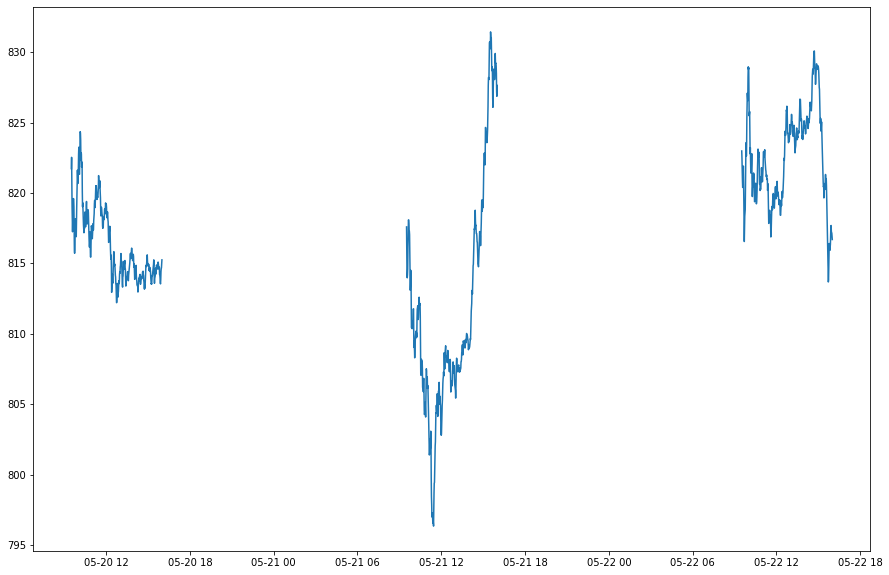

In [57]:
# visual of our current price series, clearly discontinuous overnight and mid-day on wednesday
fig, ax = plt.subplots(1, figsize=(15,10))
plt.plot(tsla_round_clock.index, tsla_round_clock.avg_price)

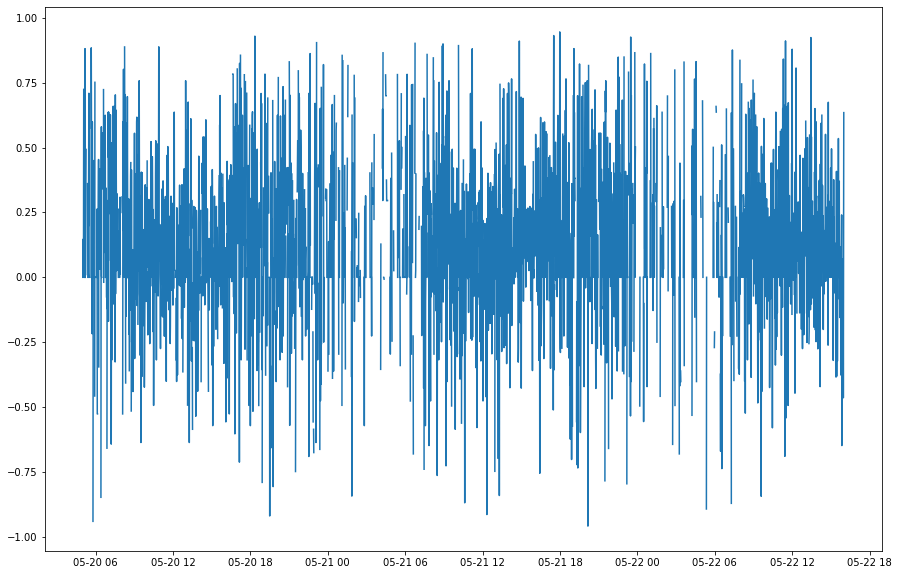

In [58]:
# visual of compound sentiment time series
fig, ax = plt.subplots(1, figsize=(15,10))
plt.plot(tsla_round_clock.index, tsla_round_clock.compound_sentiment)

In [59]:
# another pickle checkpoint
with open('pickle-folder/tsla_week2_combined.pkl', 'wb') as f:
    pickle.dump(tsla_round_clock, f)

In [60]:
# reload from pickle checkpoint
with open('pickle-folder/tsla_week2_combined.pkl', 'rb') as f:
    tsla_round_clock = pickle.load(f)
tsla_round_clock

,1. open,2. high,3. low,4. close,5. volume,avg_price,compound_sentiment,positive_sentiment,negative_sentiment,neutral_sentiment,tweet_count
0,,,,,,,,,,,
2020-05-20 05:01:00,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.00000,0.000000,1.000000,2.0
2020-05-20 05:02:00,NaN,NaN,NaN,NaN,NaN,NaN,0.146800,0.05100,0.000000,0.949000,3.0
2020-05-20 05:03:00,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.00000,0.000000,1.000000,1.0
2020-05-20 05:04:00,NaN,NaN,NaN,NaN,NaN,NaN,0.101150,0.03500,0.000000,0.965000,2.0
2020-05-20 05:05:00,NaN,NaN,NaN,NaN,NaN,NaN,0.724500,0.33600,0.000000,0.664000,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2020-05-22 15:56:00,817.4200,817.69,816.743,817.1100,29073.0,817.26500,NaN,NaN,NaN,NaN,0.0
2020-05-22 15:57:00,817.0999,817.63,816.830,817.2900,31711.0,817.19495,0.047900,0.07325,0.078250,0.848750,4.0
2020-05-22 15:58:00,817.5000,817.75,816.660,816.7896,33391.0,817.14480,-0.464467,0.00000,0.125667,0.874333,3.0


In [61]:
# fill NaN values with last valid value
tsla_round_clock1 = tsla_round_clock.fillna(method='ffill')
tsla_round_clock1['trade_volume'] = tsla_round_clock['5. volume'].fillna(0)
tsla_round_clock1['avg_price'].fillna(808.01, inplace=True)
# drop superfluous columns
tsla_round_clock1.drop(columns=['1. open','2. high','3. low','4. close', '5. volume'], inplace=True)
tsla_round_clock = tsla_round_clock1
tsla_round_clock

,avg_price,compound_sentiment,positive_sentiment,negative_sentiment,neutral_sentiment,tweet_count,trade_volume
0,,,,,,,
2020-05-20 05:01:00,808.01000,0.000000,0.000000,0.000000,1.000000,2.0,0.0
2020-05-20 05:02:00,808.01000,0.146800,0.051000,0.000000,0.949000,3.0,0.0
2020-05-20 05:03:00,808.01000,0.000000,0.000000,0.000000,1.000000,1.0,0.0
2020-05-20 05:04:00,808.01000,0.101150,0.035000,0.000000,0.965000,2.0,0.0
2020-05-20 05:05:00,808.01000,0.724500,0.336000,0.000000,0.664000,1.0,0.0
...,...,...,...,...,...,...,...
2020-05-22 15:56:00,817.26500,-0.092133,0.112667,0.111333,0.776000,0.0,29073.0
2020-05-22 15:57:00,817.19495,0.047900,0.073250,0.078250,0.848750,4.0,31711.0
2020-05-22 15:58:00,817.14480,-0.464467,0.000000,0.125667,0.874333,3.0,33391.0


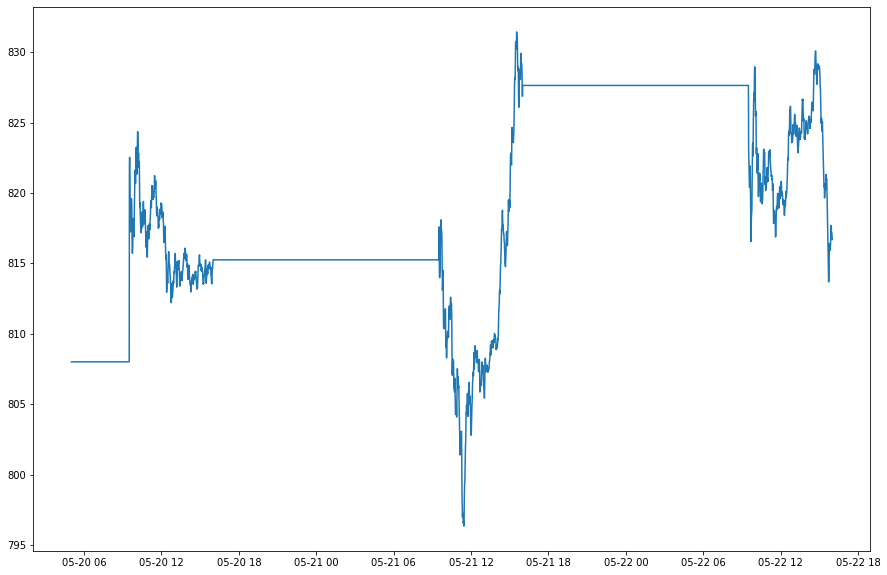

In [62]:
# visualization of our completed price series
fig, ax = plt.subplots(1, figsize=(15,10))
plt.plot(tsla_round_clock.index, tsla_round_clock.avg_price)

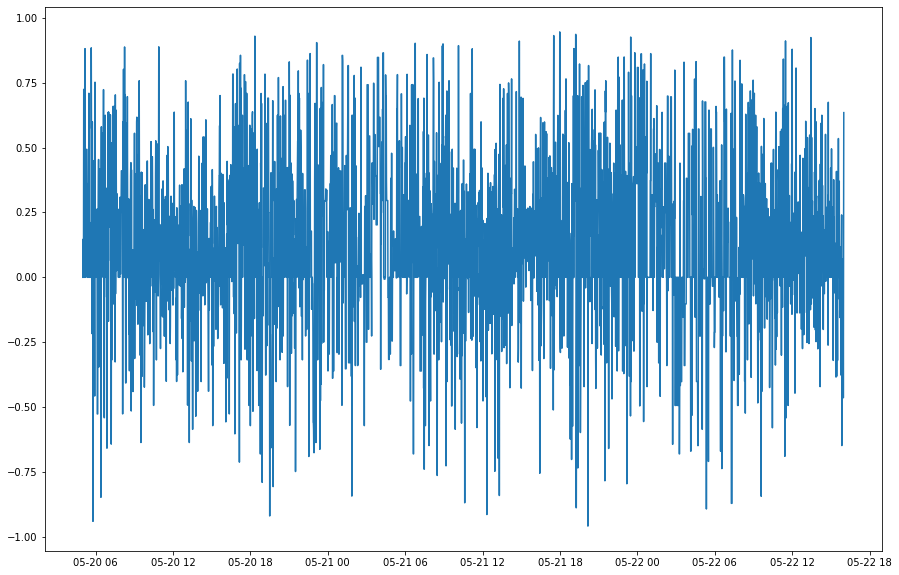

In [63]:
# visualization of our continuous compound sentiment series
fig, ax = plt.subplots(1, figsize=(15,10))
plt.plot(tsla_round_clock.index, tsla_round_clock.compound_sentiment)

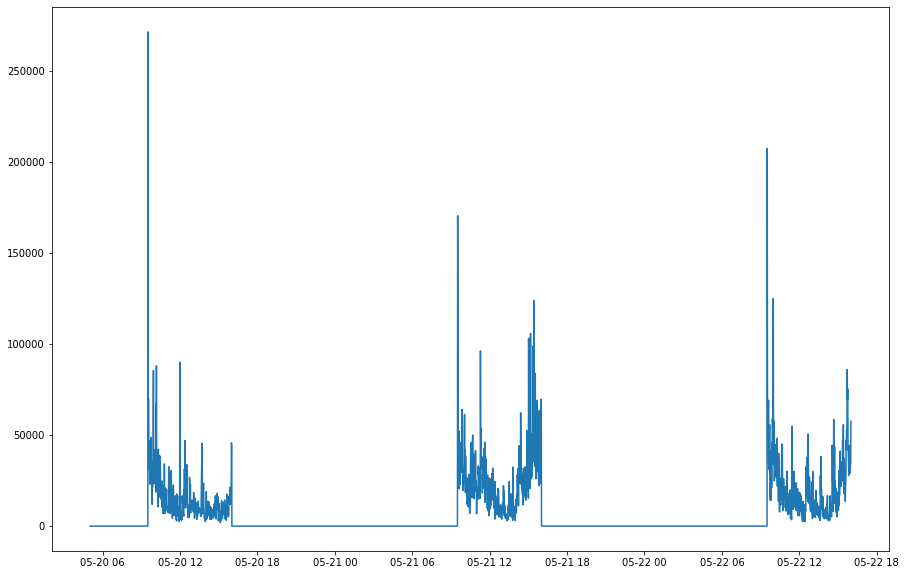

In [64]:
# visualization of our continuous trade volume series
fig, ax = plt.subplots(1, figsize=(15,10))
plt.plot(tsla_round_clock.index, tsla_round_clock['trade_volume'])

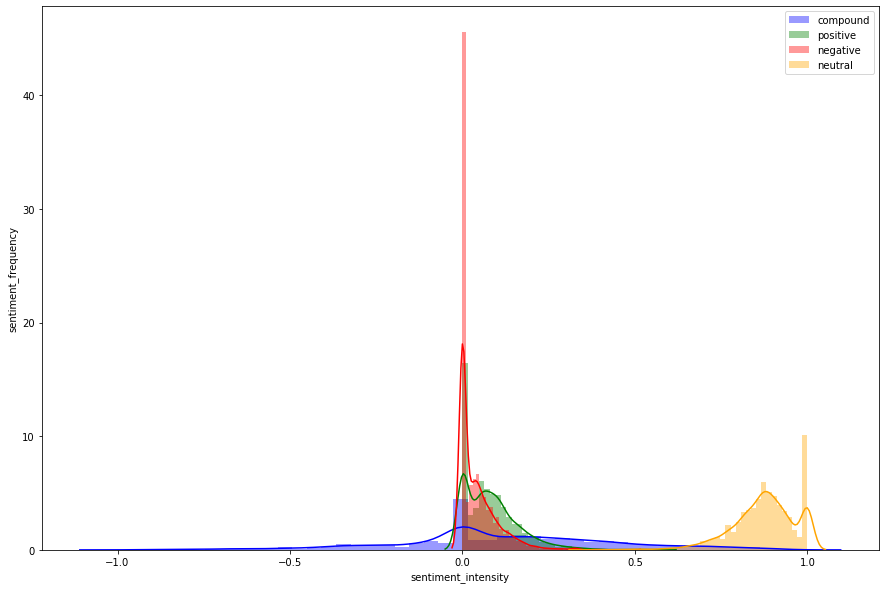

In [65]:
# frequency distribution of various types of sentiments captured
fig, ax = plt.subplots(1, figsize=(15,10), sharex=True)
sns.distplot(tsla_round_clock.compound_sentiment, color='blue', label='compound', ax=ax)
sns.distplot(tsla_round_clock.positive_sentiment, color='green', label='positive', ax=ax)
sns.distplot(tsla_round_clock.negative_sentiment, color='red', label='negative', ax=ax)
sns.distplot(tsla_round_clock.neutral_sentiment, color = 'orange', label='neutral', ax=ax)
ax.set_xlabel('sentiment_intensity')
ax.set_ylabel('sentiment_frequency')
plt.legend()

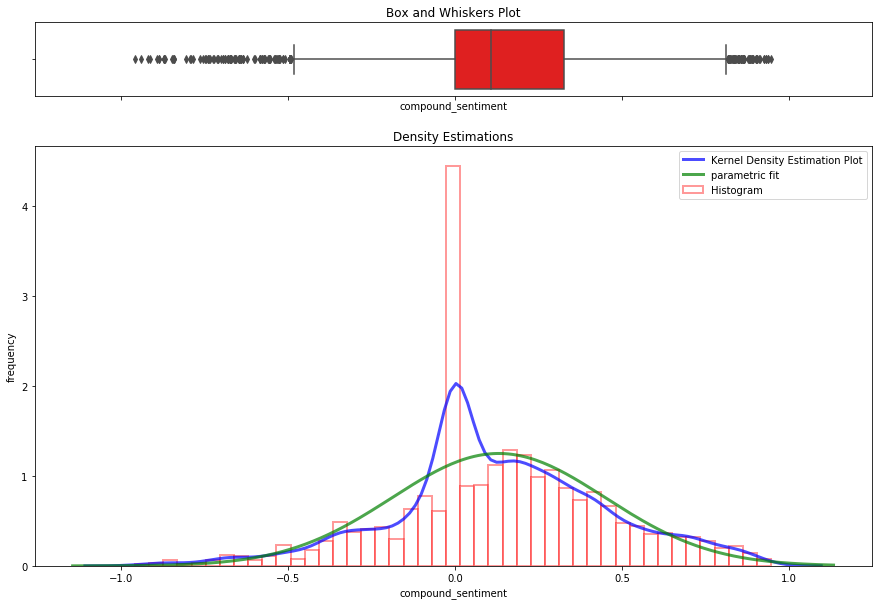

In [66]:
# more detailed visualization of compound sentiment, which we will most likely use in our final analysis
fig, (ax, ax2) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize = (15,10))

sns.distplot(tsla_round_clock.compound_sentiment, 
             hist=True, hist_kws={
                                  "linewidth": 2,
                                  "edgecolor" :'red',
                                  "alpha": 0.4, 
                                  "color":  "w",
                                  "label": "Histogram",
                                  },
             kde=True, kde_kws = {'linewidth': 3,
                                  'color': "blue",
                                  "alpha": 0.7,
                                  'label':'Kernel Density Estimation Plot'
                                 },
             fit= sp.stats.norm, fit_kws = {'color' : 'green',
                                         'label' : 'parametric fit',
                                         "alpha": 0.7,
                                          'linewidth':3},
             ax=ax2)
ax2.set_title('Density Estimations')
ax2.set_ylabel('frequency')
sns.boxplot(x=tsla_round_clock.compound_sentiment, ax = ax,color = 'red')
ax.set_title('Box and Whiskers Plot')
plt.legend();

In [67]:
# another pickle checkpoint
with open('pickle-folder/tsla_week2_combined.pkl', 'wb') as f:
    pickle.dump(tsla_round_clock, f)

In [68]:
# reload from pickle checkpoint
with open('pickle-folder/tsla_week2_combined.pkl', 'rb') as f:
    tsla_round_clock = pickle.load(f)
tsla_round_clock

,avg_price,compound_sentiment,positive_sentiment,negative_sentiment,neutral_sentiment,tweet_count,trade_volume
0,,,,,,,
2020-05-20 05:01:00,808.01000,0.000000,0.000000,0.000000,1.000000,2.0,0.0
2020-05-20 05:02:00,808.01000,0.146800,0.051000,0.000000,0.949000,3.0,0.0
2020-05-20 05:03:00,808.01000,0.000000,0.000000,0.000000,1.000000,1.0,0.0
2020-05-20 05:04:00,808.01000,0.101150,0.035000,0.000000,0.965000,2.0,0.0
2020-05-20 05:05:00,808.01000,0.724500,0.336000,0.000000,0.664000,1.0,0.0
...,...,...,...,...,...,...,...
2020-05-22 15:56:00,817.26500,-0.092133,0.112667,0.111333,0.776000,0.0,29073.0
2020-05-22 15:57:00,817.19495,0.047900,0.073250,0.078250,0.848750,4.0,31711.0
2020-05-22 15:58:00,817.14480,-0.464467,0.000000,0.125667,0.874333,3.0,33391.0


In [69]:
data = tsla_round_clock.drop(columns=['positive_sentiment', 'negative_sentiment', 'neutral_sentiment'])
data.head(1000)

,avg_price,compound_sentiment,tweet_count,trade_volume
0,,,,
2020-05-20 05:01:00,808.01000,0.000000,2.0,0.0
2020-05-20 05:02:00,808.01000,0.146800,3.0,0.0
2020-05-20 05:03:00,808.01000,0.000000,1.0,0.0
2020-05-20 05:04:00,808.01000,0.101150,2.0,0.0
2020-05-20 05:05:00,808.01000,0.724500,1.0,0.0
2020-05-20 05:06:00,808.01000,0.724500,0.0,0.0
2020-05-20 05:07:00,808.01000,0.724500,0.0,0.0
2020-05-20 05:08:00,808.01000,0.000000,1.0,0.0
2020-05-20 05:09:00,808.01000,0.000000,0.0,0.0


In [70]:
# another pickle checkpoint
with open('pickle-folder/tsla_week2_data.pkl', 'wb') as f:
    pickle.dump(data, f)

In [71]:
# reload from pickle checkpoint
with open('pickle-folder/tsla_week2_data.pkl', 'rb') as f:
    data = pickle.load(f)
data.head(1000)

,avg_price,compound_sentiment,tweet_count,trade_volume
0,,,,
2020-05-20 05:01:00,808.01000,0.000000,2.0,0.0
2020-05-20 05:02:00,808.01000,0.146800,3.0,0.0
2020-05-20 05:03:00,808.01000,0.000000,1.0,0.0
2020-05-20 05:04:00,808.01000,0.101150,2.0,0.0
2020-05-20 05:05:00,808.01000,0.724500,1.0,0.0
2020-05-20 05:06:00,808.01000,0.724500,0.0,0.0
2020-05-20 05:07:00,808.01000,0.724500,0.0,0.0
2020-05-20 05:08:00,808.01000,0.000000,1.0,0.0
2020-05-20 05:09:00,808.01000,0.000000,0.0,0.0
